<a href="https://colab.research.google.com/github/Shumin326/Wonder/blob/master/ESE545_Project1.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#problem:
- how to choose k from plots? 
- is current plots correct? if so why is the min dis bigger than 0.2?
- how to choose signature matrix size: m? now R=1,800,000
- how to choose the R of permutation pi: (a*r+b) mod R

In [0]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from numpy import vectorize
# import json
import string
from string import punctuation
from string import ascii_lowercase
import math
import timeit
from scipy import sparse
from scipy.sparse import csr_matrix
from scipy.sparse import csc_matrix
import matplotlib.pyplot as plt
import bisect

# np.random.seed(32113)

In [3]:
from google.colab import drive
drive.mount('/content/gdrive/')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/gdrive/


#P1: data preparing

In [0]:
def strip_punctuation(s):
    return ''.join(c for c in s if c not in punctuation)
root = "/content/gdrive/My Drive/ESE545/amazonReviews.json"
df_org = pd.read_json(root, lines=True)

In [184]:
q_list = ['A14CK12J7C7JRK','AKDXXW89ZLCJS','A3UE610XPFAMZS','A3C8P7DE6H7ZY5']
# for ID in q_list:
print(df_org.reviewText[0])
print(df_org.reviewText[69])
print(df_org.reviewText[167])
print(df_org.reviewText[243])
print(df_org.reviewText[377])

I purchased the Trilogy with hoping my two cats, age 3 and 5 would be interested.  The 3 yr old cat was fascinated for about 15 minutes but when the same pictures came on, she got bored.  The 5 year old watched for about a few minutes but then walked away. It is possible that because we have a wonderful courtyard full of greenery and trees and one of my neighbors has a bird feeder, that there is enough going on outside that they prefer real life versus a taped version.  I will more than likely pass this on to a friend who has cats that don't have as much wildlife to watch as mine do.
I have two cats, I bought this to help keep things clean and tidy, well it was a disaster and here is why.There is a MAJOR design flaw in this litter box, it has no solid scoop only a rake-like feature to pick up the cat waste. Well that is lovely if the waste isn't in any way still damp but if it is watch out! With the rake-like feature it dug through the waste and stuck in the scooper all the time. Then 

In [0]:
stopword = ["i", "me", "my", "myself", "we", "our", "ours", "ourselves", "you", "your", "yours", "yourself", "yourselves", "he", "him", "his", "himself", "she", "her", "hers", "herself", "it", "its", "itself", "they", "them", "their", "theirs", "themselves", "what", "which", "who", "whom", "this", "that", "these", "those", "am", "is", "are", "was", "were", "be", "been", "being", "have", "has", "had", "having", "do", "does", "did", "doing", "a", "an", "the", "and", "but", "if", "or", "because", "as", "until", "while", "of", "at", "by", "for", "with", "about", "against", "between", "into", "through", "during", "before", "after", "above", "below", "to", "from", "up", "down", "in", "out", "on", "off", "over", "under", "again", "further", "then", "once", "here", "there", "when", "where", "why", "how", "all", "any", "both", "each", "few", "more", "most", "other", "some", "such", "no", "nor", "not", "only", "own", "same", "so", "than", "too", "very", "s", "t", "can", "will", "just", "don", "should", "now"]
df_org['reviewText'] = df_org['reviewText'].str.lower()
df_org['reviewText'] = df_org['reviewText'].str.replace(r'[^\w\s]',' ')
df_org['reviewText'] = df_org['reviewText'].str.replace('_',' ')
df_org['reviewText'] = df_org['reviewText'].str.split()

In [0]:
txt_new = []
for txt in df_org['reviewText']:
    txt_new.append([word for word in txt if word not in stopword])  #delete stopwords

In [0]:
df_final = pd.DataFrame({'reviewerID':df_org['reviewerID'],'reviewText':txt_new})
df_final['reviewText']=[' '.join(item for item in x) for x in df_final['reviewText']]

In [0]:
df_final = df_final[df_final.reviewText.str.len()>3]

In [0]:
root = "/content/gdrive/My Drive/ESE545/df_final.pkl" 
df_final.to_pickle(root)

In [0]:
print(df_final)

            reviewerID                                         reviewText
0       A14CK12J7C7JRK  purchased trilogy hoping two cats age 3 5 woul...
1       A39QHP5WLON5HV  usually one cats watching tv staying trouble d...
2       A2CR37UY3VR7BN  bought triliogy tested dvds appears volume 2 w...
3       A2A4COGL9VW2HY  female kitty could care less videos cares less...
4       A2UBQA85NIGLHA  gotten volume two would given five stars since...
...                ...                                                ...
157831  A136YD08SCJ2LV  pet magasin retractable dog leash best ever us...
157832  A2YKWYC3WQJX5J  m biggest fan retractable leashes certain circ...
157833  A2K0D19N83G6U2  provided leash unbiased review 15 lb lhasa aps...
157834  A3A4ZAIBQWKOZS  well designed leash offers flexi style retract...
157835  A1ITRGMT80D5TK  leash stated good dogs 44 pounds 2 chihuahuas ...

[157678 rows x 2 columns]


#P2: K shingles
- choose k=4
- consider space and numbers
- delete reviews that is too small for k=4!!

In [0]:
root = "/content/gdrive/My Drive/ESE545/df_final.pkl" 
df_final = pd.read_pickle(root)

In [0]:
print(df_final.iloc[4778,1])

50 gallon trough goldfish clean week easy clean love


In [0]:
df_test = df_final.copy()

In [0]:
letters = ascii_lowercase+' '+'0123456789'
# ks =[i+j+k+m+n for i in letters for j in letters for k in letters for m in letters for n in letters]
ks = [i+j+k+m for i in letters for j in letters for k in letters for m in letters]

In [0]:
len_ks = len(ks)

In [0]:
dictOfWords = {ks[i]: i for i in range(len(ks))} 

In [0]:
del ks
# del df_final
# del dictOfWords
# del d

In [0]:
# k = 4
# keys = np.fromiter(Samples.keys(), dtype=float)
# d = [','.join(map(str,list(dict.fromkeys([dictOfWords.get(txt[i:i+k]) for i in range(len(txt)-k+1)])))) for txt in df_test['reviewText']]

In [0]:
k = 4
d = [np.array(list(dict.fromkeys([dictOfWords.get(txt[i:i+k]) for i in range(len(txt)-k+1)]))) for txt in df_test['reviewText']]

In [0]:
df_test.iloc[:,1] = d

In [0]:
# df_test['reviewText']= ','+ df_test.reviewText + ','

In [0]:
df_test

In [0]:
len_df = len(df_test)

In [0]:
ind_col = []
for txt in df_test.reviewText:
    ind_col += txt

In [0]:
s = max(ind_col)+1

In [0]:
data = [1]*len(ind_col)

In [0]:
df_test = df_test.reviewText.apply(len)

In [0]:
rows = df_test.values.tolist()

In [0]:
rows_list = [np.sum(rows[0:i]) for i in range(1,len(rows))]

In [0]:
rows_list_new = [0]+rows_list

In [0]:
rows_list_new = np.array(rows_list_new)

In [0]:
j = 0
ind_row = []
for i in rows:
    ind_row += [j]*i
    j += 1
    

In [0]:
ar_dense = csr_matrix((data,(ind_row, ind_col)), shape=(len_df,s))

In [54]:
print(ar_dense)

  (0, 8388)	1
  (0, 15433)	1
  (0, 16032)	1
  (0, 16602)	1
  (0, 20686)	1
  (0, 23410)	1
  (0, 24249)	1
  (0, 24724)	1
  (0, 24793)	1
  (0, 25334)	1
  (0, 26092)	1
  (0, 26162)	1
  (0, 26703)	1
  (0, 26978)	1
  (0, 30142)	1
  (0, 33833)	1
  (0, 62237)	1
  (0, 65886)	1
  (0, 70452)	1
  (0, 70466)	1
  (0, 101754)	1
  (0, 102027)	1
  (0, 102035)	1
  (0, 110907)	1
  (0, 111040)	1
  :	:
  (157677, 1347631)	1
  (157677, 1347725)	1
  (157677, 1349851)	1
  (157677, 1356335)	1
  (157677, 1356520)	1
  (157677, 1356557)	1
  (157677, 1357643)	1
  (157677, 1357654)	1
  (157677, 1357704)	1
  (157677, 1360384)	1
  (157677, 1360590)	1
  (157677, 1403794)	1
  (157677, 1404403)	1
  (157677, 1456224)	1
  (157677, 1463083)	1
  (157677, 1464428)	1
  (157677, 1504612)	1
  (157677, 1505026)	1
  (157677, 1506877)	1
  (157677, 1506893)	1
  (157677, 1606030)	1
  (157677, 1606406)	1
  (157677, 1613659)	1
  (157677, 1657590)	1
  (157677, 1707342)	1


In [0]:
root = '/content/gdrive/My Drive/ESE545/ar_dense.npz'
sparse.save_npz(root, ar_dense)
# ar_dense = sparse.load_npz(root)

In [0]:
# root = "/content/gdrive/My Drive/ESE545/df_dense_4_array_based.pkl" 
# df_test.to_pickle(root)

#P3: data visualization

In [0]:
root = "/content/gdrive/My Drive/ESE545/df_dense_4.pkl" 
df_dense = pd.read_pickle(root)

In [173]:
print(df_dense.iloc[243,0])

A3C8P7DE6H7ZY5


In [0]:
ind = np.random.randint(0,157678,size=[10000,2])
dis_set = []
for i in range(10000):
    df_rand_pair = df_dense.iloc[ind[i],1]
    df_rand_1 = df_rand_pair.iloc[0]
    df_rand_2 = df_rand_pair.iloc[1]
    sim = 0
    for num in df_rand_1:
        if num in df_rand_2:
            sim += 1
    sim = sim/(len(df_rand_1)+len(df_rand_2)-sim)
    dis = 1-sim
    dis_set.append(dis)
dis_set = np.array(dis_set)

In [0]:
mean = np.mean(dis_set)
min_dis = np.min(dis_set)

In [0]:
print(mean,min_dis)

0.9717749323392454 0.8663101604278075


Text(0.5, 1.0, 'data distribution with k=4')

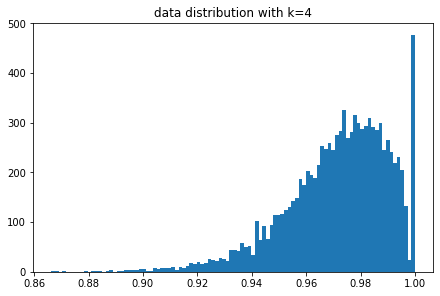

In [0]:
fig, axs = plt.subplots(1, 1, constrained_layout=True)
axs.hist(dis_set,100)
axs.set_title('data distribution with k=4')

#P4: Signature matrix & bands
- m = 300, r = 12, b = 25


In [0]:
root = '/content/gdrive/My Drive/ESE545/ar_dense.npz'
ar_dense = sparse.load_npz(root)

In [0]:
print(ar_dense)

In [157]:
m = 300
first_one_ind = np.zeros((157678,m))
for i in range(m):
    index = np.random.permutation(s)
    ar_permuted = ar_dense[:,index]
    row,col = ar_permuted.nonzero()
    col = col[rows_list_new]
    first_one_ind[:,i] = col
first_one_ind = first_one_ind.astype(int)
root = '/content/gdrive/My Drive/ESE545/ar_signature.npy'
np.save(root,first_one_ind)

NameError: ignored

In [0]:
# start = timeit.default_timer()
# m = 200
# R = len_ks
# coef = np.random.randint(1,2*m,size=[m,2])
# df_signature = pd.DataFrame(np.random.rand(len(df_test),m+1))
# ind = 1
# for a,b in coef:
#     df_a = (a*df_test.reviewText+b)%R
#     # df_signature.iloc[:,ind] = np.vectorize(min)(df_a)
#     # df_signature.iloc[:,ind] = list(map(min,df_a))
#     df_a.apply(min)
#     df_signature.iloc[:,ind] = df_a
#     ind += 1
# root = "/content/gdrive/My Drive/ESE545/df_signature.pkl" 
# df_signature.to_pickle(root)
# stop = timeit.default_timer()
# print(stop-start)

In [0]:
# start = timeit.default_timer()
# m = 3
# R = len_ks
# df_signature = pd.DataFrame(np.random.rand(len(df_test),m))
# a_test = np.random.randint(1,m+1,size = [1,m])
# b_test = np.random.randint(0,m,size = [1,m])
# df_t = np.array(df_test.reviewText.to_numpy()).reshape(-1,1)
# df_t = (df_t @ a_test + b_test)%R
# df_signature.iloc[:,:] = df_t
# for i in range(m):
#     df_signature = df_signature.iloc[:,i]
# # root = "/content/gdrive/My Drive/ESE545/df_signature.pkl" 
# # df_signature.to_pickle(root)
# stop = timeit.default_timer()
# print(stop-start)


In [0]:
# start = timeit.default_timer()
# m = 100
# R = len_ks
# new_txt = np.zeros((len(df_dense),m))
# for i in range(m):
#     a = np.random.randint(1,int(np.sqrt(m))+2)
#     b = np.random.randint(0,int(np.sqrt(m))+2)
#     for i in range(R):
#         df_test['signature'] = df_test.reviewText.str.contains((','+str((a*i+b) % R)+','))]
#         if j%1000==0:
#             stop = timeit.default_timer()
#             print(j,'time=',stop-start)
     

In [0]:
root = '/content/gdrive/My Drive/ESE545/ar_signature.npy'
ar_signature = np.load(root)

In [0]:
ar_signature.astype(int)

In [0]:
def seive(n):
    mask = np.ones(n+1)
    mask[:2] = 0
    for i in range(2, int(n**.5)+1):
        if not mask[i]:
            continue
        mask[i*i::i] = 0
    return np.argwhere(mask)

def get_nearest_prime(old_number):
    try:
        n = np.max(seive(2*old_number-1))
        if n < old_number+1:
            return None
        return n
    except ValueError:
        return None

In [101]:
get_nearest_prime(1000000)

1999993

In [0]:
m = 300
r = 12
b = 25  # b = m/r
P = 1999993
coef = np.random.randint(1,P-1,size = [r,2])

In [0]:
for a,b in coef:
    print(a,b)

In [154]:
j = 0
ar_bands = np.zeros((len(ar_signature),b))
for v in ar_signature:
    v = v.reshape(b,r)  #v: b*r
    sum_ = np.zeros(b)  
    for i in range(r):  
        sum_ += (coef[i,0]*v[:,i]+coef[i,1])%P
        sum_.reshape(1,-1) #return 1*n
    ar_bands[j] = sum_
    j += 1
ar_bands = ar_bands.astype(int)
root = '/content/gdrive/My Drive/ESE545/ar_bands.npy'
np.save(root,ar_bands)

ValueError: ignored

#P5: detect pairs

In [0]:
root = '/content/gdrive/My Drive/ESE545/ar_bands.npy'
ar_bands = np.load(root)

In [0]:
h_value_distinct = list(dict.fromkeys(list(ar_bands.reshape(-1))))

In [0]:
bucket_len = len(h_value_distinct)

In [0]:
buckets = []
j = 0
last_dup_inds = np.array([])
for bucket in h_value_distinct:
    sp_ar_bands = csr_matrix(ar_bands==bucket) 
    dup_inds = sp_ar_bands.nonzero()[0]
    if 1-np.array_equal(dup_inds,last_dup_inds):
        buckets.append(dup_inds)
        last_dup_inds = dup_inds
    j += 1
    if j%5000==0:
        print(j,buckets)

In [147]:
print(buckets[0][0:100])

[    0    69   167   243   377   720   749   841  1048  1050  1216  1452
  1642  1651  1847  2445  2684  2823  2914  2956  2960  2961  2995  3000
  3004  3033  3401  3476  3483  3686  3837  4165  4570  4608  4612  4616
  4804  5491  5529  5532  5726  5833  6016  6024  6037  6133  6134  6480
  6575  6730  6846  6873  7296  7327  7566  7792  7854  7868  7900  7975
  7983  7991  8056  8110  8254  8257  8258  8527  8863  8866  8867  8869
  8881  8892  8966  9024  9050  9074  9095  9319 10202 10452 10585 10609
 10633 10641 10656 10709 10836 11102 11138 11155 11157 11162 11180 11190
 11240 11278 11288 11294]


In [119]:
51693/4855

10.647373841400618

In [84]:
# a = np.array([[1,2,3,2],[1,3,4,2]])
bk = np.where(a==5)[0]
print(np.array_equal(bk,np.array([])))

True


In [74]:
a = np.array([1,2,3])
b = np.array([1,6,7])
np.any(a == b)

True

3750000

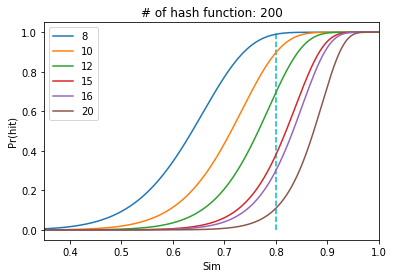

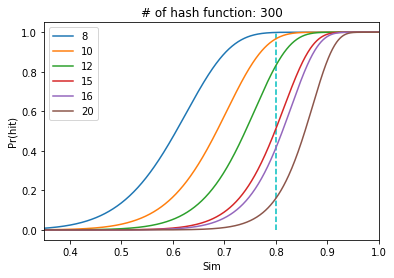

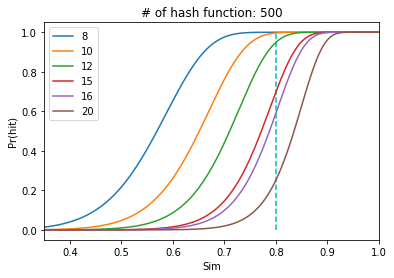

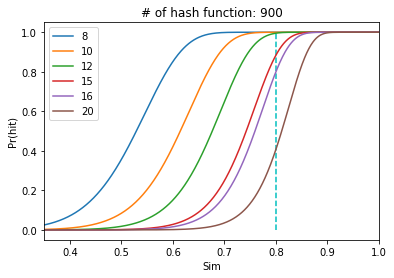

In [152]:
# choose r,b and m
Ms = [200,300,500,900] # The possible value of M(the number of hash function)
s = np.arange(0,1,0.001) # The range of similarity
for m in Ms:
    r = [8,10,12,15,16,20]
    b = [m/i for i in r]
    for i in range(len(r)):        
        plt.plot(s,1-(1-s**r[i])**b[i])
    plt.vlines(0.8, 0, 1, colors = "c", linestyles = "dashed")
    plt.legend(labels = r, loc = 'best')
    plt.xlim(0.35, 1)
    plt.xlabel('Sim')
    plt.ylabel('Pr(hit)')
    plt.title("# of hash function: %i" % m)
    plt.show()